# A/B тест «Чат с менеджером» на сайте онлайн-ритейлера

<a name="Содержание"></a> 
### Содержание:
0. [Описание проекта, описание данных, загрузка и импорт библиотек](#0.)
1. [Загрузка датасета, первичный осмотр](#1.)
2. [Предобработка данных](#2.)
3. [Исследовательский анализ данных](#3.)  
    3.1. [Воронка событий](#3.1.)  
    3.2. [Связанная воронка событий](#3.2.)  
    3.3. [Несвязанная воронка событий](#3.3.)  
    3.4. [Исследование различий в тестовых группах](#3.4.)  
    3.5. [Конверсия в группах](#3.5.)  
4. [A/B тестирование](#4.)
5. [Выводы](#5.)

<a name="0."></a>
## 0. Описание проекта [↑](#Содержание)

«Чат с менеджером» представляет собой онлайн-чат на сайте, подобный JivoSite. Основной задачей менеджера является консультация посетителя об особенностях товара (сложный технический товар). Требуется оценить влияние чата на конверсию, найти инсайты в пути клиента до покупки.

#### Описание данных [↑](#Содержание)

Датасет состоит из 154788 записей, где каждая запись - одно событие.  Данные собирались с 25.07.2019 по 05.08.2019
В датасете собрана информация о регистрируемых событиях, их дате и тестовой группе, к которой отнесен UID.

Описание данных **ab_log.csv:**  
**`event`** — событие  
**`user_id`** — id пользователя  
**`EventTime`** — время события  
**`Group`** — группа события
  
Значения колонки **Group**:  
**`A1`** — контрольная группа  
**`A2`** — контрольная группа  
**`B`** `— экспериментальная группа  

#### Импорт библиотек [↑](#Содержание)

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import math as mth
from scipy import stats as st

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a name="1."></a>
### 1. Загрузка датасета, первичный осмотр [↑](#Содержание)

In [45]:
path = 'C:/Users/sergey/desktop/'
df = pd.read_csv(path + 'ab_log.csv')

In [46]:
df.head(3)

,event,user_id,EventTime,Group
0,StartReadingOffer,7241586465170049200,1564978321,A2
1,OpenProductCard,4998498972125515821,1564678223,A2
2,StartReadingOffer,5794343176311717876,1564681595,B


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154788 entries, 0 to 154787
Data columns (total 4 columns):
event        154788 non-null object
user_id      154788 non-null int64
EventTime    154788 non-null int64
Group        154788 non-null object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


В датафрейме отсутствуют аномальные значения (со знаком минус и пр.), категорийные значения имеют однотипное написание, каждому UID соответствует одна группа.
Наблюдаются проблемы:
  - колонка `eventtime` приведена к типу `int`, переведем её в `datetime`
  - переименуем для удобства названия колонок
  - найдены полные дубликаты

<a name="2."></a>
### 2. Предобработка данных [↑](#Содержание)

In [48]:
# переименуем столбцы
df.columns = ['event', 'userid', 'eventtime', 'group']

In [49]:
# приведем колонку eventtime к типу datetime
df['eventtime'] = pd.to_datetime(df['eventtime'], unit='s')
# создадим новый столбец с датой
df['date'] = df['eventtime'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [50]:
print("Всего найдено дубликатов: {}".format(df.duplicated().sum()))
print("Дубликаты составляют {:.2%} от общей длины датафрейма".format(df.duplicated().sum() / len(df)))
df[df.duplicated(keep=False)].sort_values(by=['userid', 'event']).head(4)

Всего найдено дубликатов: 296
Дубликаты составляют 0.19% от общей длины датафрейма


,event,userid,eventtime,group,date
5217,StartCheckProduct,33176906335348434,2019-08-04 16:06:03,B,2019-08-04
80036,StartCheckProduct,33176906335348434,2019-08-04 16:06:03,B,2019-08-04
38754,StartReadingOffer,33176906335348434,2019-08-04 15:54:35,B,2019-08-04
142894,StartReadingOffer,33176906335348434,2019-08-04 15:54:35,B,2019-08-04


In [51]:
# удалим дубликаты
df.drop_duplicates(inplace=True)

------------

Посмотрим на распределение `eventtime`

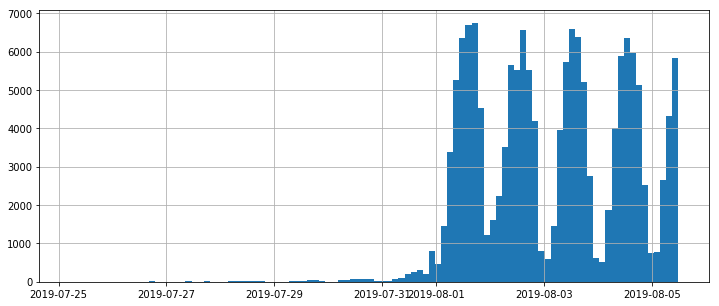

In [52]:
df['eventtime'].hist(figsize=(12,5), bins=100)

Видим, что с 25 июля по 1 августа записей значительно меньше, по сравнению с последующим периодом. Это может быть связано с техническими проблемами. За 5 августа данные присутсвуют лишь за половину дня.  
Сделаем слудующее:
  - посмотрим сколько уникальных UID содержится в период до 1 августа, чтобы понять объем данных, которые мы потенциально потеряем
  - исключим все записи до 1 августа и после 4 августа. Причем, создадим список UID, которые встречались до 01.08 и удалим их из последующего периода, так как по данным пользователям могла некорректно записываться информация (сессии  до 01.08 могли оказать влияние на сессии в выбранный период).
  - записи после 04.08 удалим без удаления событий UID, которые приходятся на период 01.08.2019 - 04.08.2019

In [53]:
# Период 25.07.2019-01.08.2019
unique_id_abnormal_period = df.query('"2019-08-01" > date')[['userid']].nunique()['userid']
events_abnormal_period = df.query('"2019-08-01" > date')[['event']].count()['event']
events_per_unique_id_abnormal_period = (events_abnormal_period / unique_id_abnormal_period).round(0).astype('int')

# Период 01.08.2019-04.08.2019 до очистки
unique_id_normal_period = df.query('("2019-08-01" <= date <= "2019-08-04")')[['userid']].nunique()['userid']
events_normal_period = df.query('("2019-08-01" <= date <= "2019-08-04")')[['event']].count()['event']
events_per_unique_id_normal_period = (events_normal_period / unique_id_normal_period).round(0).astype('int')

# ВСЕГО
unique_id = df['userid'].nunique()
events_all = df['event'].count()
events_per_unique_id_all = (events_all / unique_id).round(0).astype('int')

# создаем список всех ID присутствовавших до 01.08.2019
drop_id_list = df.query('"2019-08-01" > date')['userid'].unique()
# исключаем из датасета лист с данными ID
df_tidy = df[np.logical_not(df['userid'].isin(drop_id_list))]

# "Чистые данные"
tidy_unique_id = df_tidy.query('("2019-08-01" <= date <= "2019-08-04")')[['userid']].nunique()['userid']
tidy_events = df_tidy.query('("2019-08-01" <= date <= "2019-08-04")')[['event']].count()['event']
tidy_events_per_unique_id = (tidy_events / tidy_unique_id).round(0).astype('int')

# "Исключенные" данные
del_unique_id = unique_id_normal_period - tidy_unique_id
del_events = events_normal_period - tidy_events
del_events_per_unique_id = (del_events / del_unique_id).round(0).astype('int')

# Таблица
df_stats_periods = {'': ['Период 25.07.2019-01.08.2019 (исключаемые данные)', 'Период 01.08.2019-04.08.2019', '"Чистые данные" 01.08.2019-04.08.2019','"Исключенные данные"', "Всего"],\
                         'Уникальные ID': [unique_id_abnormal_period, unique_id_normal_period, tidy_unique_id, del_unique_id, unique_id],\
                         'События': [events_abnormal_period, events_normal_period, tidy_events, del_events, events_all],\
                         'Количество событий / ID': [events_per_unique_id_abnormal_period, events_per_unique_id_normal_period, tidy_events_per_unique_id, del_events_per_unique_id, events_per_unique_id_all]}

df_stats = pd.DataFrame(data=df_stats_periods).set_index('')
df_stats.head()

,Уникальные ID,События,Количество событий / ID
,,,
Период 25.07.2019-01.08.2019 (исключаемые данные),1448,2814,2
Период 01.08.2019-04.08.2019,6553,137901,21
"""Чистые данные"" 01.08.2019-04.08.2019",5192,104439,20
"""Исключенные данные""",1361,33462,25
Всего,6805,154492,23


- в исключаемом периоде 25.07.2019-01.08.2019 видно значительно меньшее количество событий, приходящихся на 1 юзера. Вероятно, не все события записывались.
- исключено 1361 USERID, что составляет 20% от общего числа USERID.
- при исключении данных в выбранном периоде количество событий на 1 юзера сократилось с 21 до 20. Это значит, что исключенные USERID имели события, приходящихся и на "чистый период".
- более 90% USERID исключаемого периода встречаются в период 01.08.2019 - 04.08.2019. Это значит, что для пользователей характерно заходить несколько раз в неделю.

In [54]:
print("Исключено {} ({:.0%}) уникальных USERID, и {} ({:.0%}) событий.".format(del_unique_id, (del_unique_id / unique_id),\
                                                                del_events, (del_events / events_all)))


Исключено 1361 (20%) уникальных USERID, и 33462 (22%) событий.


Возможности оставить эти данные нет, так как в этом случае в "чистых данных" будут юзеры, которые уже могли пройти часть воронки. Результаты теста могут сместиться.  
Также удалим данные за 05.08.2019, но не будем исключать эти UID из "чистого периода". Удалить данные записи стоит, так как они собраны лишь за половину дня.

In [55]:
df = df_tidy[df_tidy['date'] != "2019-08-05"].copy()

<a name="3."></a>
### 3. Исследовательский анализ данных [↑](#Содержание)

<a name="3.1."></a>
#### 3.1. Воронка событий [↑](#Содержание)

In [56]:
df.groupby('event').agg({'userid':'nunique'}).sort_values('userid', ascending=False)

,userid
event,
StartReadingOffer,5082
StartCheckProduct,3073
OpenPaymentScreen,2607
OpenProductCard,2484


Воронка продаж проиходит таким образом:  
   -  **`StartReadingOffer`** -   просмотр предложения, стартовая страница
   -  **`StartCheckProduct`** -   изучение продукта
   -  **`OpenProductCard`** -  открытие страницы корзины
   -  **`OpenPaymentScreen`** - открытие страницы оплаты

<a name="3.2."></a>
#### 3.2. Связанная воронка событий [↑](#Содержание)

Создадим таблицу, где для каждого USERID выделим минимальное время каждого из событий, а затем проследим количество юзеров, которые последовательно проходят по шагам.

In [57]:
# сделаем сводную таблицу, в которой отобразим для каждого USERID минимальное время каждого из событий
df_pivot = df.pivot_table(index='userid', columns='event', values = 'eventtime', aggfunc='min') \
                                       .reset_index() \
# создадим фильтры, в которых каждое последующее событие у юзера будет позже, чем время предыдущего события
level_1 = df_pivot['StartReadingOffer'].notnull()
level_2 = level_1 & (df_pivot['StartReadingOffer'] <= df_pivot['StartCheckProduct'])
level_3 = level_2 & (df_pivot['StartCheckProduct'] <= df_pivot['OpenProductCard'])
level_4 = level_3 & (df_pivot['OpenProductCard'] <= df_pivot['OpenPaymentScreen'])

# значение каждого из событий
StartReadingOffer = df_pivot[level_1].shape[0]
StartCheckProduct = df_pivot[level_2].shape[0]
OpenProductCard = df_pivot[level_3].shape[0]
OpenPaymentScreen = df_pivot[level_4].shape[0]

# создаем таблицу
funnel = pd.DataFrame({'events': ['StartReadingOffer', 'StartCheckProduct',  'OpenProductCard', 'OpenPaymentScreen'], \
                      'unique_id': [StartReadingOffer, StartCheckProduct, OpenProductCard, OpenPaymentScreen]})

funnel.head()

,events,unique_id
0,StartReadingOffer,5082
1,StartCheckProduct,2790
2,OpenProductCard,1124
3,OpenPaymentScreen,657


In [58]:
# строим воронку
fig = go.Figure(go.Funnel(
    y = funnel['events'],
    x = funnel['unique_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

- общая конверсия составляет 13%  
- минимальная конверсия происходит на шаге **`StartCheckProduct`** -> **`OpenProductCard`**, составляет 40%
- на других шагах колеблется от 55% до 59%

-------------

<a name="3.3."></a>
#### 3.3. Несвязанная воронка событий [↑](#Содержание)

In [59]:
# сгруппируем данные
events_stats = df.groupby('event')\
                                     .agg({'event': 'count', 'userid':'nunique'})\
                                     .rename({'event':'count_events', 'userid': 'unique_id'}, axis=1)\
                                     .sort_values('count_events', ascending=False)\
                                     .reset_index()
# добавим столбцы процентного соотношения
events_stats['ratio_id_from_StartReadingOffer'] = (events_stats['unique_id'] / events_stats['unique_id'][0])\
                                                                            .apply(lambda x: '{:.2%}'.format(x))

events_stats['ratio_id_all'] = (events_stats['unique_id'] / events_stats['unique_id'].sum())\
                                                                            .apply(lambda x: '{:.2%}'.format(x))

pct_change=[100]
for j in range(1,len(events_stats['unique_id'])):
    pct_change.append(int(round(events_stats['unique_id'][j]/events_stats['unique_id'][j-1]*100)))
events_stats['ratio_from_previous'] = pct_change
events_stats['ratio_from_previous'] = events_stats['ratio_from_previous'].apply(lambda x: '{}%'.format(x))
events_stats.head()

,event,count_events,unique_id,ratio_id_from_StartReadingOffer,ratio_id_all,ratio_from_previous
0,StartReadingOffer,48628,5082,100.00%,38.37%,100%
1,StartCheckProduct,20822,3073,60.47%,23.20%,60%
2,OpenProductCard,19202,2484,48.88%,18.75%,81%
3,OpenPaymentScreen,15787,2607,51.30%,19.68%,105%


- конверсия для несвязанной конверсии выше - 51,3%
- по результатам очевидно, что часть клиентов пропускают некоторые из шагов.

<a name="3.4."></a>
#### 3.4. Исследование различий в тестовых группах [↑](#Содержание)

In [60]:
check_groups = df.groupby(['date', 'group']).agg({'event':'count','userid':'nunique'})
check_groups['ratio_event_uniq'] = (check_groups['event'] / check_groups['userid']).round(2)
check_groups

event  userid  ratio_event_uniq
date       group                                 
2019-08-01 A1      9016     985              9.15
           A2      8140     929              8.76
           B       9194     919             10.00
2019-08-02 A1      8246     940              8.77
           A2      8325     950              8.76
           B      10682     934             11.44
2019-08-03 A1      8608     911              9.45
           A2      7548     889              8.49
           B       9136     914             10.00
2019-08-04 A1      7468     904              8.26
           A2      8739     933              9.37
           B       9337     929             10.05

При разбиении по дням и группам видно, что разбиение по количеству UID примерно равное. Отмечаются особенности:
  
- среднее количество событий на пользователя колеблется в диапозоне 8-9,5 на юзера, тогда как по полным данным оно составляет около 20. Это значит, что пользователи чаще всего осуществляют покупку в течение более, чем 1 день.

- в группе B во все дни эксперимента наблюдается повышенное отношение событий на пользователя, в сравнении с другими группами.

In [61]:
event_per_userid = df.groupby(['group', 'event']).agg({'event':'count','userid':'nunique'})
event_per_userid['event_uid'] = event_per_userid['event'] / event_per_userid['userid']
event_per_userid

event  userid  event_uid
group event                                      
A1    OpenPaymentScreen   4810     865   5.560694
      OpenProductCard     5778     822   7.029197
      StartCheckProduct   6734    1018   6.614931
      StartReadingOffer  16016    1699   9.426722
A2    OpenPaymentScreen   4612     891   5.176207
      OpenProductCard     5784     844   6.853081
      StartCheckProduct   6477    1050   6.168571
      StartReadingOffer  15879    1680   9.451786
B     OpenPaymentScreen   6365     851   7.479436
      OpenProductCard     7640     818   9.339853
      StartCheckProduct   7611    1005   7.573134
      StartReadingOffer  16733    1703   9.825602

В группе B лишь незначительно выросло количество событий открытия стартовой страницы при ходящихся на 1 юзера. Значительно выросло количество последующих событий: изучения продукта, открытия коризны и открытие страницы оплаты.

-------

**Рассмотрим распределение событий во времени (округление до часов)**

Text(0, 0.5, 'Количество событий')

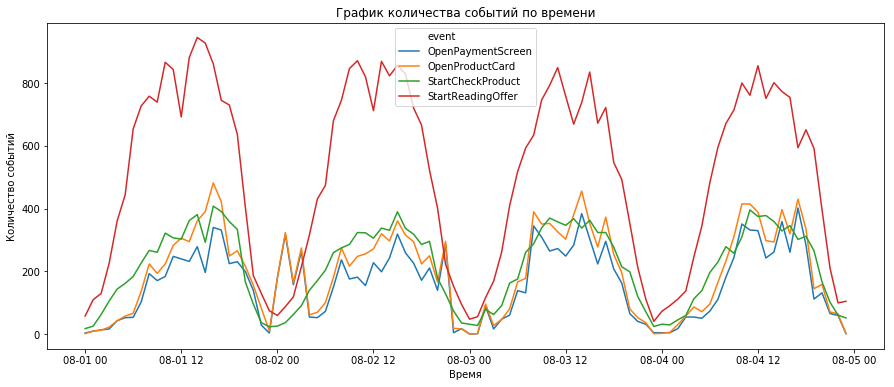

In [62]:
# создадим колонку datetime, с округлением до 1 часа
df['datetimehour'] = df['eventtime'].apply(lambda x: datetime(x.year, x.month, x.day, x.hour))
# сгруппируем данные
datetimehour_group = df.groupby(['event', 'datetimehour'], as_index=False)['userid'].count()

# график
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="datetimehour", y="userid", hue = 'event', data=datetimehour_group)
ax.set_title("График количества событий по времени")
ax.set_xlabel("Время")
ax.set_ylabel("Количество событий")

На графике наблюдается несколько интересных вещей:
  - день недели не влияет на популярность сервиса (3 и 4 августа - выходные)
  - на посещение влияет время суток, однако если днём `StartReadingOffer` значительно больше относительно других событий, то поздним вечером-ночью это соотношение значительно сокращается
  - в ночь с 01-08-2019 на 02-08-2019 наблюдается картина, когда количество событий `OpenProductCard`, `OpenPaymentScreen` превышают `StartReadingOffer`. Пик поменьше виднеется и в ночь с 02-08-2019 на 03-08-2019

----------

**Рассмотрим соотношение событий по тестовым группам**

Text(0, 0.5, 'Количество событий')

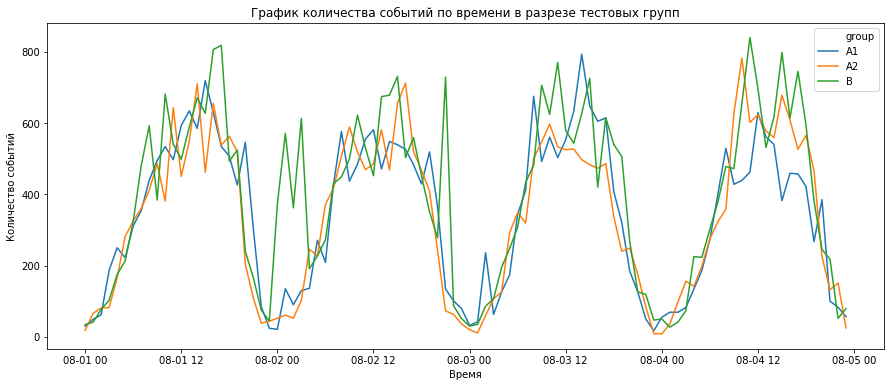

In [63]:
yo = df.groupby(['group', 'datetimehour']).agg({'event':'count'}).reset_index()
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="datetimehour", y="event", hue = 'group', data=yo)
ax.set_title("График количества событий по времени в разрезе тестовых групп")
ax.set_xlabel("Время")
ax.set_ylabel("Количество событий")

- пики событий группы B соотносятся по времени с пиками предыдущего графика
- в целом в группе B наблюдается больше пиков и они более высокие в сравнении с другими группами

-----

**Рассмотрим график событий в группе B**

Text(0, 0.5, 'Количество событий')

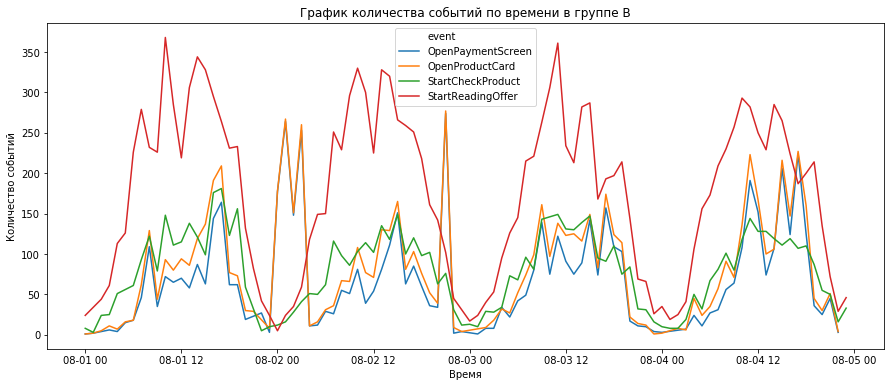

In [64]:
yo = df[df['group'] == 'B'].groupby(['event', 'datetimehour']).agg({'userid':'count'}).reset_index()
plt.figure(figsize=(15, 6)) # Важно! Этот код нужно писать до момента создания графика
ax = sns.lineplot(x="datetimehour", y="userid", hue = 'event', data=yo)
ax.set_title("График количества событий по времени в группе B")
ax.set_xlabel("Время")
ax.set_ylabel("Количество событий")

- помимо выше упомянутых ночных пиков видим значительные повышения событий `OpenProductCard` и `OpenPaymentScreen` 04-08-2019

------------

<a name="3.5."></a>
#### 3.5. Конверсия в группах [↑](#Содержание)

За конверсию будем считать количество уникальныз юзеров, дошедших до шага `OpenPaymentScreen` к общему количеству юзеров.

In [65]:
# сгруппируем данные по количеству уникальных посетителей и кол-во переходов на 'OpenPaymentScreen'
# (на 1 уникального посетителя до 1 перехода)
nunique = df.groupby(['date', 'group']).agg({'userid':'nunique'})\
                                       .reset_index()\
                                       .rename({'userid':'userid_unique'}, axis=1)

event = df[df['event'] == "OpenPaymentScreen"].groupby(['date', 'group'])\
                                              .agg({'userid':'nunique'})\
                                              .reset_index()\
                                              .rename({'userid':'OpenPaymentScreen'}, axis=1)

conversion = nunique.merge(event, on=['date', 'group'])

conversion['conversion'] = conversion['OpenPaymentScreen'] / conversion['userid_unique']
conversion.head()

,date,group,userid_unique,OpenPaymentScreen,conversion
0,2019-08-01,A1,985,386,0.391878
1,2019-08-01,A2,929,371,0.399354
2,2019-08-01,B,919,384,0.417845
3,2019-08-02,A1,940,379,0.403191
4,2019-08-02,A2,950,402,0.423158


['2019-08-01', '2019-08-04', 0.36, 0.48]

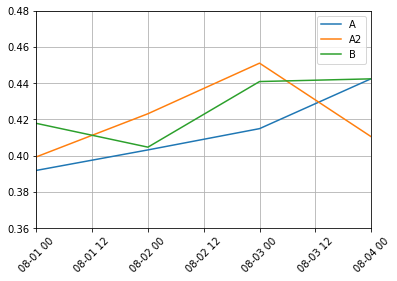

In [66]:
conversion_A1 = conversion.query('group == "A1"')
conversion_A2 = conversion.query('group == "A2"')
conversion_B = conversion.query('group == "B"')

# строим график
plt.plot(conversion_A1['date'], conversion_A1['conversion'], label='A')
plt.plot(conversion_A2['date'], conversion_A2['conversion'], label='A2')
plt.plot(conversion_B['date'], conversion_B['conversion'], label='B')

plt.axhline(y=0, color='black', linestyle='--')
plt.tick_params(axis='x', rotation=45)
plt.grid()
plt.legend()
plt.axis(["2019-08-01", '2019-08-04', 0.36, 0.48])

Конверсия в группе B выше в первый день, затем колеблется между A1 и A2. По графику нельзя сказать, что какая-либо из групп имеет более высокую конверсию по сравнению с другими.

<a name="4."></a>
### 4. A/B тестирование [↑](#Содержание)

In [67]:
# сгруппируем данные по событиям и найдем количество уникальных посетителей
def groups_groupby (group_number):
    group = df.query('group == @group_number')\
                                    .groupby('event')\
                                    .agg({'userid':'nunique'})\
                                    .sort_values('userid', ascending=False)\
                                    .reset_index()
    for i in range(1, len(group), 1):
        group.loc[i, 'ratio'] = ((group.loc[i, 'userid'] / group.loc[0, 'userid']).round(2))
    group=group.fillna(1)
    group['ratio'] = group['ratio'].map(lambda x: '{:.2%}'.format(x))
    return group
# применим функцию
group_A1 = groups_groupby("A1")
group_A2 = groups_groupby("A2")
group_B = groups_groupby("B")
group_A1

,event,userid,ratio
0,StartReadingOffer,1699,100.00%
1,StartCheckProduct,1018,60.00%
2,OpenPaymentScreen,865,51.00%
3,OpenProductCard,822,48.00%


#### A/A тестирование

Проверим у контрольных групп A1 и A2 разбиение на равные доли с помощью z-теста. Посмотрим на различия в разности долей каждого из событий от общего числа пользователей группы.

In [68]:
def z_test_func(successes_1, trials_1, successes_2, trials_2):
    
    # критический уровень статистической значимости
    alpha = .05
    # пропорция успехов в первой группе:
    p1 = successes_1/trials_1
    # пропорция успехов во второй группе:
    p2 = successes_2/trials_2
    # пропорция успехов в датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        
for i in range(0, len(group_A1), 1):
    print("\t\t\t\t\t"+group_A1.loc[i, 'event'])
    (z_test_func(group_A1.loc[i, 'userid'], group_A1['userid'].sum(), group_A2.loc[i, 'userid'], group_A2['userid'].sum()))
    print ("\n")

					StartReadingOffer
p-значение:  0.35568209179987287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					StartCheckProduct
p-значение:  0.6553019287548096
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenPaymentScreen
p-значение:  0.7106375560293365
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenProductCard
p-значение:  0.7744302355510726
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




В контрольных группах с высокой степенью достоверности одинаковые результаты, то есть разбиение похоже на корректное.

#### Проверка контрольных групп с тестовой

**- проведем z-тест между контрольной группой A1 и тестовой B.**

In [69]:
for i in range(0, len(group_A1), 1):
    print("\t\t\t\t\t"+group_A1.loc[i, 'event'])
    (z_test_func(group_A1.loc[i, 'userid'], group_A1['userid'].sum(), group_B.loc[i, 'userid'], group_B['userid'].sum()))
    print ("\n")

					StartReadingOffer
p-значение:  0.7514200248086154
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					StartCheckProduct
p-значение:  0.863579107651641
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenPaymentScreen
p-значение:  0.8143818623466637
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenProductCard
p-значение:  0.9772220064406745
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**- проведем z-тест между контрольной группой A2 и тестовой B.**

In [70]:
for i in range(0, len(group_A2), 1):
    print("\t\t\t\t\t"+group_A2.loc[i, 'event'])
    (z_test_func(group_A2.loc[i, 'userid'], group_A2['userid'].sum(), group_B.loc[i, 'userid'], group_B['userid'].sum()))
    print ("\n")

					StartReadingOffer
p-значение:  0.21495910446896116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					StartCheckProduct
p-значение:  0.5365071111876685
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenPaymentScreen
p-значение:  0.544530113505004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


					OpenProductCard
p-значение:  0.7967998889086578
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- в тестовых и контрольных группах с высокой степенью достоверности одинаковые результаты, то есть доли всех событий вероятнее всего равны.

<a name="4."></a>
### 4. Выводы [↑](#Содержание)

**A/B тестирование**  
Согласно результатам Z-теста с высокой степенью достоверности можно утверждать, что доли всех событий у контрольных и тестовой группы одинаковы. Рекомендуется остановить тест и признать результат неудачным и оставить версию сайта без чата.


**Общее:**
1. Среднее дневное количество событий на юзера составляет 8-10, тогда как по полным данным оно составляет около 20. Это значит, что пользователи чаще всего осуществляют покупку в течении более чем 1 дня.
2. Замечены суточные особенности в количестве событий. Днём событий `StartReadingOffer` значительно больше относительно других событий, поздним вечером-ночью это соотношение значительно сокращается.
3. Конверсия в связанной воронке составляет 13%, конверсия для несвязанной конверсии выше - 51,3%.
4. По разнице в конверсиях очевидно, что многие клиенты пропускают некоторые из шагов.
5. Дни недели не влияют на посещение.

**Особенности тестовой B группы:**
1. В группе B во все дни эксперимента наблюдается повышенное количество событий на пользователя, в сравнении с другими группами.
2. В ночь с 01-08-2019 на 02-08-2019 наблюдается картина, когда количество событий `OpenProductCard`, `OpenPaymentScreen` превышают `StartReadingOffer`. Пик поменьше виднеется и в ночь с 02-08-2019 на 03-08-2019.
3. В группе B наблюдается больше пиков и они более высокие в сравнении с другими группами.